# 3D Reconstruction 

In this notebook, we will reconstruct a 3D model of a landmark using multiple images from the Heritage-Recon dataset.

#### Imports

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import least_squares

# add imports here

### Dataset Loading & Preprocessing
Similar to what we did in Task 1, but instead of only a few images, we will now load in and preprocess all the images in our dataset


It has 4 different dataset paths, one is 1400 images of pantheon, one is 1360 images of brandenburg, one is 91 images of pantheon  (currently in use), one is 109 images of brandenburg

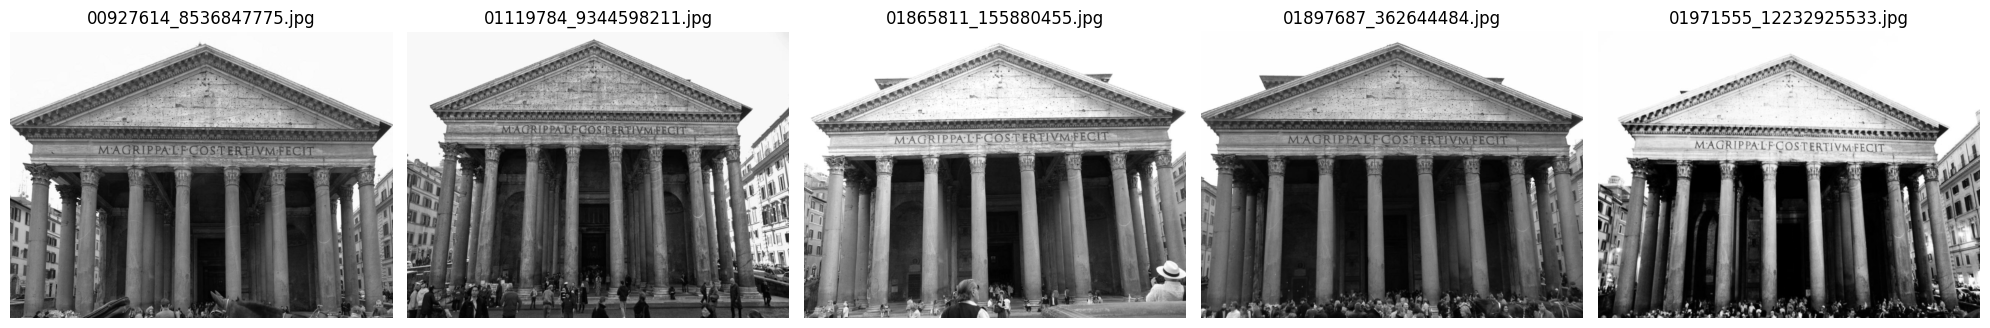

Loaded 70 images from the dataset.


In [8]:
# your code here
# your code here

# dataset_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\pantheon_exterior\pantheon_exterior\dense\images"
# dataset_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\brandenburg_gate\brandenburg_gate\dense\images\images"
# dataset_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\brandenburg_gate\brandenburg_gate\dense\images"
dataset_path = r"pantheon_exterior\pantheon_exterior\dense\images\selected_imgs"
# def load_images_from_folder(folder_path, resize_shape=(800, 600)):
#     """Loads and preprocesses all images from the given folder."""
#     images = []
#     image_names = []
#     for filename in sorted(os.listdir(folder_path)):
#         if filename.lower().endswith(".jpg"):
#             image_path = os.path.join(folder_path, filename)
#             img = cv2.imread(image_path)
#             if img is not None:
#                 img_resized = cv2.resize(img, resize_shape)
#                 img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
#                 images.append(img_gray)
#                 image_names.append(filename)
#     return images, image_names
import os
import cv2

def load_images_from_folder(folder_path, resize_shape=(800, 600)):
    """Loads and preprocesses all images from the given folder, skipping the first two files."""
    images = []
    image_names = []
    # Sort the filenames and skip the first two
    filenames = sorted(os.listdir(folder_path))[:70]
    for filename in filenames:
        if filename.lower().endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)
            if img is not None:
                img_resized = cv2.resize(img, resize_shape)
                img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
                images.append(img_gray)
                image_names.append(filename)
    return images, image_names



images, image_names = load_images_from_folder(dataset_path)


fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(image_names[i])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

print(f"Loaded {len(images)} images from the dataset.")


In [91]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Define ROI for the Brandenburg Gate (adjust as per your images)
# roi_x, roi_y, roi_width, roi_height = 50, 50, 600, 600  # Example values, tweak as needed

# # Function to apply ROI mask
# def apply_roi(image, x, y, width, height):
#     mask = np.zeros_like(image, dtype=np.uint8)
#     cv2.rectangle(mask, (x, y), (x + width, y + height), 255, -1)
#     return cv2.bitwise_and(image, mask)

# # Limit to the first 20 images
# for i, img in enumerate(images[:20]):  # Slice to take only the first 20 images
#     img_with_roi = apply_roi(img, roi_x, roi_y, roi_width, roi_height)
    
#     # Display the original and ROI-applied images
#     plt.figure(figsize=(12, 6))
    
#     # Original image
#     plt.subplot(1, 2, 1)
#     plt.imshow(img, cmap='gray')
#     plt.title(f"Original Image {i}")
#     plt.axis("off")
    
#     # Image with ROI applied
#     plt.subplot(1, 2, 2)
#     plt.imshow(img_with_roi, cmap='gray')
#     plt.title(f"Image {i} with ROI")
#     plt.axis("off")
    
#     plt.show()


### Feature Detection & Matching (Across Multiple Images)
Extending what we did in Task 1, we will now extract the features from each image and match these features across all the images. However, this time you might want to consider extracting the best matches instead of all of them for each pair. Using the best matches improves the accuracy and reliability of our feature matching, which is crucial for the success of subsequent stages. Filtering out bad matches reduces the chance of errors propagating throughout the pipeline and results in a more robust and accurate 3D model.

Also display the results of feature detection and matching for any pair of images.

# Tried ROI bounding and match distance threshold in this

In [5]:
# import cv2
# import matplotlib.pyplot as plt

# # Initialize SIFT with more features
# sift = cv2.SIFT_create(nfeatures=5000)

# # Initialize list to store pairwise matches
# all_pairwise_matches = []

# # Iterate through consecutive image pairs
# print(f"Processing {len(images) - 1} consecutive image pairs...")
# for i in range(len(images) - 1):
#     img1 = images[i]
#     img2 = images[i + 1]

#     # Detect and compute keypoints and descriptors
#     kp1, des1 = sift.detectAndCompute(img1, None)
#     kp2, des2 = sift.detectAndCompute(img2, None)

#     # Use BFMatcher to find matches
#     bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # crossCheck=False for Lowe's ratio test
#     matches = bf.knnMatch(des1, des2, k=2)

#     # Apply Lowe's ratio test to filter matches
#     ratio_threshold = 0.8  # Relax the threshold to 0.8
#     good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

#     # Sort matches by distance and keep the top matches
#     top_matches = sorted(good_matches, key=lambda x: x.distance)[:40]  # Keep top 200 matches

#     # Save the matches for this pair
#     all_pairwise_matches.append((i, i + 1, top_matches))

#     # Visualize matches for a specific pair (optional)
#     if i == 0:  # Visualize the first pair for debugging
#         img_matches = cv2.drawMatches(
#             img1, kp1, img2, kp2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
#         )
#         plt.figure(figsize=(15, 10))
#         plt.imshow(img_matches)
#         plt.title(f"Feature Matches: Image {i} and Image {i+1}")
#         plt.axis("off")
#         plt.show()

#     print(f"Processed image pair {i} and {i + 1}: Found {len(top_matches)} good matches.")

# print(f"Feature matching completed for {len(all_pairwise_matches)} consecutive image pairs.")

# # import cv2
# # import matplotlib.pyplot as plt

# # # Initialize SIFT with more features
# # sift = cv2.SIFT_create(nfeatures=5000)

# # # Initialize list to store pairwise matches
# # all_pairwise_matches = []

# # # Define ROI for the Brandenburg Gate (adjust as per your images)
# # roi_x, roi_y, roi_width, roi_height = 100, 100, 500, 400  # Example values, tweak as needed

# # # Function to apply ROI mask
# # def apply_roi(image, x, y, width, height):
# #     mask = cv2.rectangle(
# #         np.zeros_like(image, dtype=np.uint8), (x, y), (x + width, y + height), 255, -1
# #     )
# #     return cv2.bitwise_and(image, mask)

# # # Iterate through consecutive image pairs
# # print(f"Processing {len(images) - 1} consecutive image pairs...")
# # for i in range(len(images) - 1):
# #     # Apply ROI to both images
# #     # img1 = apply_roi(images[i], roi_x, roi_y, roi_width, roi_height)
# #     # img2 = apply_roi(images[i + 1], roi_x, roi_y, roi_width, roi_height)
# #     img_1 = images[i]
# #     img_2 = images[i+1]

# #     # Detect and compute keypoints and descriptors
# #     kp1, des1 = sift.detectAndCompute(img1, None)
# #     kp2, des2 = sift.detectAndCompute(img2, None)

# #     # Use BFMatcher to find matches
# #     bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # crossCheck=False for Lowe's ratio test
# #     matches = bf.knnMatch(des1, des2, k=2)

# #     # Apply Lowe's ratio test to filter matches
# #     ratio_threshold = 0.75  # Adjust threshold as needed
# #     good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

# #     # Additional filtering: Average match distance threshold
# #     avg_distance = sum([m.distance for m in good_matches]) / len(good_matches) if good_matches else float('inf')
# #     distance_threshold = 200  # Set a threshold for average match distance
# #     good_matches = [m for m in good_matches if avg_distance < distance_threshold]

# #     # Append matches only if they meet quality criteria
# #     if len(good_matches) > 30:
# #         all_pairwise_matches.append((i, i + 1, good_matches))

# #     # Visualize matches for the first pair (optional)
# #     if i == 0:  # Visualize the first pair for debugging
# #         img_matches = cv2.drawMatches(
# #             images[i], kp1, images[i + 1], kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
# #         )
# #         plt.figure(figsize=(15, 10))
# #         plt.imshow(img_matches)
# #         plt.title(f"Feature Matches: Image {i} and Image {i+1}")
# #         plt.axis("off")
# #         plt.show()

# #     print(f"Processed image pair {i} and {i + 1}: Found {len(good_matches)} good matches.")

# # print(f"Feature matching completed for {len(all_pairwise_matches)} consecutive image pairs.")


Processing pairwise combinations for 70 images...


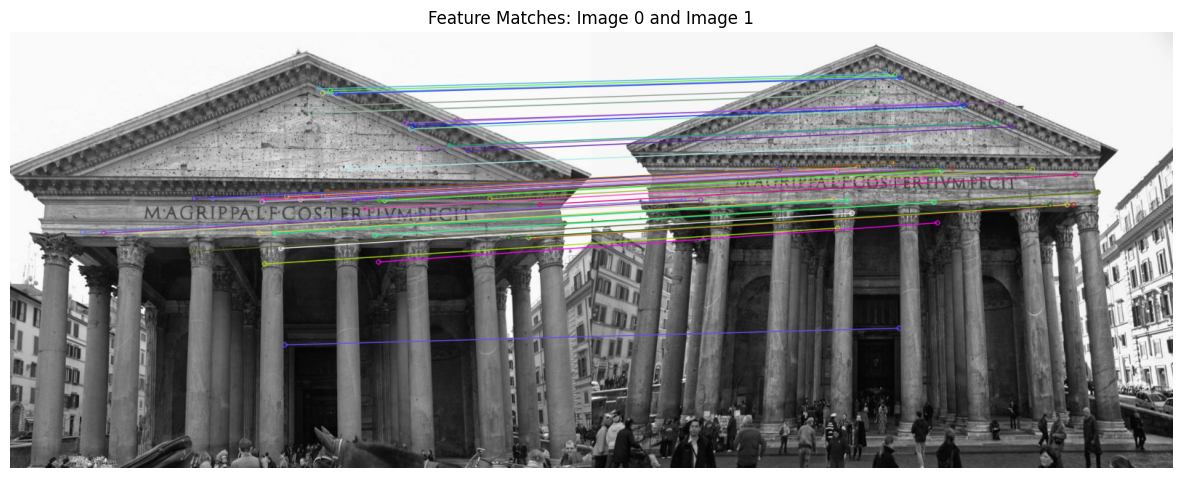

Processed image pair 0 and 1: Found 50 good matches.
Processed image pair 0 and 2: Found 50 good matches.
Processed image pair 0 and 3: Found 50 good matches.
Processed image pair 0 and 4: Found 50 good matches.
Processed image pair 0 and 5: Found 50 good matches.
Processed image pair 0 and 6: Found 50 good matches.
Processed image pair 0 and 7: Found 50 good matches.
Processed image pair 0 and 8: Found 50 good matches.
Processed image pair 0 and 9: Found 50 good matches.
Processed image pair 0 and 10: Found 50 good matches.
Processed image pair 0 and 11: Found 50 good matches.
Processed image pair 0 and 12: Found 50 good matches.
Processed image pair 0 and 13: Found 50 good matches.
Processed image pair 0 and 14: Found 50 good matches.
Processed image pair 0 and 15: Found 50 good matches.
Processed image pair 0 and 16: Found 50 good matches.
Processed image pair 0 and 17: Found 50 good matches.
Processed image pair 0 and 18: Found 50 good matches.
Processed image pair 0 and 19: Found 

In [14]:

sift = cv2.SIFT_create(nfeatures=5000)

all_pairwise_matches = []

print(f"Processing pairwise combinations for {len(images)} images...")
for i in range(len(images)):
    img1 = images[i]
    
    for j in range(i + 1, len(images)):
        img2 = images[j]

        kp1, des1 = sift.detectAndCompute(img1, None)
        kp2, des2 = sift.detectAndCompute(img2, None)

        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  
        matches = bf.knnMatch(des1, des2,k=2)
        # matches = sorted(matches, key=lambda x: x.distance)

        ratio_threshold = 0.7
        good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

        top_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

        all_pairwise_matches.append((i, j, top_matches))

        if i == 0 and j == 1:  
            img_matches = cv2.drawMatches(
                img1, kp1, img2, kp2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
            plt.figure(figsize=(15, 10))
            plt.imshow(img_matches)
            plt.title(f"Feature Matches: Image {i} and Image {j}")
            plt.axis("off")
            plt.show()

        print(f"Processed image pair {i} and {j}: Found {len(top_matches)} good matches.")

print(f"Feature matching completed for {len(all_pairwise_matches)} image combinations.")


# Tried something but didn't really achieve it

In [ ]:
# import numpy as np
# import open3d as o3d

# def generate_brandenburg_gate():
#     points = []
#     colors = []

#     # Base dimensions
#     base_width = 20
#     base_depth = 10
#     base_height = 3

#     # Column dimensions
#     column_width = 2
#     column_spacing = 5
#     column_height = 12
#     num_columns = 5

#     # Top structure dimensions
#     top_width = base_width
#     top_depth = base_depth
#     top_height = 3

#     # Colors
#     base_color = [0.5, 0.35, 0.05]  # Brownish
#     column_color = [0.8, 0.8, 0.8]  # Light gray
#     top_color = [0.7, 0.7, 0.7]     # Gray

#     # Generate points for the base
#     for x in np.linspace(-base_width / 2, base_width / 2, 50):
#         for z in np.linspace(-base_depth / 2, base_depth / 2, 50):
#             for y in np.linspace(0, base_height, 5):
#                 points.append([x, y, z])
#                 colors.append(base_color)

#     # Generate points for the columns
#     for i in range(num_columns):
#         column_center_x = -base_width / 2 + column_spacing + i * column_spacing
#         for x in np.linspace(column_center_x - column_width / 2, column_center_x + column_width / 2, 10):
#             for z in np.linspace(-base_depth / 4, base_depth / 4, 10):
#                 for y in np.linspace(base_height, base_height + column_height, 30):
#                     points.append([x, y, z])
#                     colors.append(column_color)

#     # Generate points for the top structure
#     top_y_start = base_height + column_height
#     for x in np.linspace(-top_width / 2, top_width / 2, 50):
#         for z in np.linspace(-top_depth / 2, top_depth / 2, 50):
#             for y in np.linspace(top_y_start, top_y_start + top_height, 10):
#                 points.append([x, y, z])
#                 colors.append(top_color)

#     return np.array(points), np.array(colors)

# # Generate the point cloud
# points_3D, colors_3D = generate_brandenburg_gate()

# # Create Open3D point cloud
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_3D)
# pcd.colors = o3d.utility.Vector3dVector(colors_3D)

# # Generate a mesh using Poisson surface reconstruction
# print("Generating mesh...")
# pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
# mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
# mesh.compute_vertex_normals()

# # Apply color to the mesh
# mesh.paint_uniform_color([0.8, 0.8, 0.8])  # Light gray for realism

# # Visualize the point cloud and mesh
# print("Visualizing point cloud and mesh...")
# o3d.visualization.draw_geometries([pcd], window_name="Brandenburg Gate Point Cloud")
# o3d.visualization.draw_geometries([mesh], window_name="Brandenburg Gate Mesh")


Generating mesh...
Visualizing point cloud and mesh...
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


### Camera Pose Estimation (Global)
We will estimate the relative camera poses (position and orientation) between consecutive image pairs. You can use the same technique as you did in Task 1 or switch to one of the others mentioned in the announcement on Slack.

In [ ]:
# your code here

def parse_cameras_txt(file_path):
    cameras = {}
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.strip().split()
            camera_id = int(parts[0])
            model = parts[1]
            width = int(parts[2])
            height = int(parts[3])
            params = list(map(float, parts[4:]))
            fx, cx, cy = params[0], params[1], params[2]
            K = np.array([[fx, 0, cx],
                          [0, fx, cy],
                          [0, 0, 1]])
            cameras[camera_id] = {"model": model, "width": width, "height": height, "K": K}
    return cameras

def parse_images_txt(file_path):
    images = {}
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.strip().split()
            try:
                image_id = int(parts[0])
            except ValueError:
                continue
            qw, qx, qy, qz = map(float, parts[1:5])
            tx, ty, tz = map(float, parts[5:8])
            camera_id = int(parts[8])
            image_name = parts[9]
            images[image_name] = {
                "image_id": image_id,
                "qvec": [qw, qx, qy, qz],
                "tvec": [tx, ty, tz],
                "camera_id": camera_id
            }
    return images


def quaternion_to_rotation_matrix(qvec):
    qw, qx, qy, qz = qvec
    R = np.array([
        [1 - 2 * (qy ** 2 + qz ** 2), 2 * (qx * qy - qz * qw), 2 * (qx * qz + qy * qw)],
        [2 * (qx * qy + qz * qw), 1 - 2 * (qx ** 2 + qz ** 2), 2 * (qy * qz - qx * qw)],
        [2 * (qx * qz - qy * qw), 2 * (qy * qz + qx * qw), 1 - 2 * (qx ** 2 + qy ** 2)]
    ])
    return R

def extract_camera_and_pose(images, cameras, image_name):
    if image_name not in images:
        raise ValueError(f"Image {image_name} not found in images.txt")
    image_data = images[image_name]
    camera_id = image_data["camera_id"]
    if camera_id not in cameras:
        raise ValueError(f"Camera ID {camera_id} not found in cameras.txt")
    K = cameras[camera_id]["K"]
    qvec = image_data["qvec"]
    tvec = np.array(image_data["tvec"])
    R = quaternion_to_rotation_matrix(qvec)
    return K, R, tvec

cameras_txt_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\pantheon_exterior\pantheon_exterior\output_txt\cameras.txt"
images_txt_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\pantheon_exterior\pantheon_exterior\output_txt\images.txt"
# cameras_txt_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\brandenburg_gate\brandenburg_gate\output_txt\cameras.txt"
# images_txt_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\brandenburg_gate\brandenburg_gate\output_txt\images.txt"
# Parse camera and image data
cameras = parse_cameras_txt(cameras_txt_path)
images_extracted = parse_images_txt(images_txt_path)

In [ ]:
camera_poses = {}  # Format: {image_name: (R_global, T_global)}

origin_image_name = image_names[0] 
K_origin, R_origin, T_origin = extract_camera_and_pose(images_extracted, cameras, origin_image_name)

camera_poses[origin_image_name] = (R_origin, T_origin)
print(f"Initialized origin pose for {origin_image_name}: R shape {R_origin.shape}, T shape {T_origin.shape}")

for idx, (i, j, matches) in enumerate(all_pairwise_matches):
    img1_name = image_names[i]
    img2_name = image_names[j]
    print(f"\nProcessing pair {idx + 1}/{len(all_pairwise_matches)}: {img1_name} and {img2_name}")

    try:
        K1, _, _ = extract_camera_and_pose(images_extracted, cameras, img1_name)
        K2, _, _ = extract_camera_and_pose(images_extracted, cameras, img2_name)
    except ValueError as e:
        print(f"Skipping pair {img1_name} and {img2_name}: {e}")
        continue

    img1 = images[i]
    img2 = images[j]
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    pts1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)
    print(f"Matched points: {pts1.shape[0]} pairs")

    if pts1.shape[0] < 8:
        print(f"Skipping pair {img1_name} and {img2_name}: Not enough matches ({pts1.shape[0]})")
        continue
    F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    if F is None or F.shape != (3, 3):
        print(f"Skipping pair {img1_name} and {img2_name}: Invalid Fundamental Matrix")
        continue
    E = K2.T @ F @ K1
    # Recover relative pose (img2 relative to img1)
    _, R_relative, T_relative, mask = cv2.recoverPose(E, pts1, pts2, K1)
    print(f"Recovered R shape: {R_relative.shape}, T shape: {T_relative.shape}")
    T_relative = T_relative.reshape(-1, 1)
    # Transform img2's pose into the global frame relative to the origin
    if img1_name in camera_poses:
        R1_global, T1_global = camera_poses[img1_name]
        T1_global = T1_global.reshape(-1,1)

        # Compute the global pose for img2 relative to the origin
        R2_global = R1_global @ R_relative
        T2_global = R1_global @ T_relative + T1_global
        camera_poses[img2_name] = (R2_global, T2_global)
        print(f"Updated global pose for {img2_name} relative to origin: R shape {R2_global.shape}, T shape {T2_global.shape}")

    else:
        print(f"Skipping pair {img1_name} and {img2_name}: Missing global pose for {img1_name}")

print(f"\nCamera pose estimation completed for {len(camera_poses)} images relative to the origin")


Initialized origin pose for 00927614_8536847775.jpg: R shape (3, 3), T shape (3,)

Processing pair 1/2415: 00927614_8536847775.jpg and 01119784_9344598211.jpg
Matched points: 1439 pairs
Recovered R shape: (3, 3), T shape: (3, 1)
Updated global pose for 01119784_9344598211.jpg relative to origin: R shape (3, 3), T shape (3, 1)

Processing pair 2/2415: 00927614_8536847775.jpg and 01865811_155880455.jpg
Matched points: 1272 pairs
Recovered R shape: (3, 3), T shape: (3, 1)
Updated global pose for 01865811_155880455.jpg relative to origin: R shape (3, 3), T shape (3, 1)

Processing pair 3/2415: 00927614_8536847775.jpg and 01897687_362644484.jpg
Matched points: 1461 pairs
Recovered R shape: (3, 3), T shape: (3, 1)
Updated global pose for 01897687_362644484.jpg relative to origin: R shape (3, 3), T shape (3, 1)

Processing pair 4/2415: 00927614_8536847775.jpg and 01971555_12232925533.jpg
Matched points: 1056 pairs
Recovered R shape: (3, 3), T shape: (3, 1)
Updated global pose for 01971555_122

### Choosing the technique
For this task, you have been given the choice of using either Structure from Motion (SfM) or Photogrammetry as your reconstruction method. A brief overview of the steps involved in each technique has been included in the handout provided to you. You can choose either technique for this task but before you choose one be sure to do a bit more research on each technique. I have also added some resources below to help you in understanding each technique.

[Understanding Structure From Motion Algorithms](https://medium.com/@loboateresa/understanding-structure-from-motion-algorithms-fc034875fd0c)\
[SfM](https://cmsc426.github.io/sfm/)\
[Chapter 13 - Structure from motion](https://mi.eng.cam.ac.uk/~cipolla/publications/contributionToEditedBook/2008-SFM-chapters.pdf)\
[What is Photogrammetry?](https://www.artec3d.com/learning-center/what-is-photogrammetry)\
[The Multi-View Environment](https://github.com/simonfuhrmann/mve)\
[open Multi-View Stereo](https://github.com/cdcseacave/openMVS)\
[Surface Reconstruction](https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html)

**Technique chosen:** SFM

### 3D Reconstruction
Once you have chosen the technique, you can now start working on actually 3D reconstruction. Depending on the technique, follow the pipeline to generate the 3D point cloud for your landmark.

In [12]:
all_3D_points = []  # List to store all triangulated 3D points

# Iterate over all image pairs in the matches
for idx, (i, j, matches) in enumerate(all_pairwise_matches):
    img1_name = image_names[i]
    img2_name = image_names[j]

    print(f"\nProcessing pair {idx + 1}/{len(all_pairwise_matches)}: {img1_name} and {img2_name}")

    # Check if both images have valid global poses
    if img1_name not in camera_poses or img2_name not in camera_poses:
        print(f"Skipping pair {img1_name} and {img2_name}: Missing global pose for one or both images.")
        continue

    # Get global poses for img1 and img2
    R1, T1 = camera_poses[img1_name]
    R2, T2 = camera_poses[img2_name]

    # Get intrinsic matrices for both images
    K1, _, _ = extract_camera_and_pose(images_extracted, cameras, img1_name)
    K2, _, _ = extract_camera_and_pose(images_extracted, cameras, img2_name)

    # Compute projection matrices
    P1 = K1 @ np.hstack((R1, T1.reshape(-1, 1)))
    P2 = K2 @ np.hstack((R2, T2.reshape(-1, 1)))

    # Retrieve matched keypoints
    img1 = images[i]
    img2 = images[j]
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    pts1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)

    # Skip if not enough matches
    if pts1.shape[0] < 8:
        print(f"Skipping pair {img1_name} and {img2_name}: Not enough matches ({pts1.shape[0]}).")
        continue

    # Perform triangulation
    points_4D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3D = (points_4D[:3] / points_4D[3]).T  # Convert homogeneous to 3D points

    print(f"Triangulated {points_3D.shape[0]} 3D points for pair {img1_name}-{img2_name}")

    # Append points to the global list
    all_3D_points.append(points_3D)

# Combine all 3D points into a single array
if all_3D_points:
    final_3D_points = np.vstack(all_3D_points)
    print(f"Total triangulated 3D points: {final_3D_points.shape[0]}")
else:
    print("No 3D points could be triangulated.")
# Initialize point ID counter and storage
# point_id_counter = 0
# points_3D_dict = {}  # Format: {point_id: (x, y, z)}
# point_2D_mapping = []  # Format: [(image_id, point_id, x, y)]

# During triangulation
# for idx, (i, j, matches) in enumerate(all_pairwise_matches):
#     img1_name = image_names[i]
#     img2_name = image_names[j]
#     R1, T1 = camera_poses[img1_name]
#     R2, T2 = camera_poses[img2_name]
#     K1, _, _ = extract_camera_and_pose(images_extracted, cameras, img1_name)
#     K2, _, _ = extract_camera_and_pose(images_extracted, cameras, img2_name)

#     P1 = K1 @ np.hstack((R1, T1.reshape(-1, 1)))
#     P2 = K2 @ np.hstack((R2, T2.reshape(-1, 1)))

#     img1 = images[i]
#     img2 = images[j]
#     kp1, des1 = sift.detectAndCompute(img1, None)
#     kp2, des2 = sift.detectAndCompute(img2, None)

#     # Get matched keypoints
#     pts1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
#     pts2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)

#     # Perform triangulation
#     points_4D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
#     points_3D = (points_4D[:3] / points_4D[3]).T  # Convert homogeneous to 3D points

#     # Assign point IDs and store
#     for pt_idx, (x, y, z) in enumerate(points_3D):
#         point_id = point_id_counter
#         point_id_counter += 1
#         points_3D_dict[point_id] = (x, y, z)

#         # Map 2D points to the generated point ID
#         point_2D_mapping.append((images_extracted[img1_name]['image_id'], point_id, pts1[pt_idx, 0], pts1[pt_idx, 1]))
#         point_2D_mapping.append((images_extracted[img2_name]['image_id'], point_id, pts2[pt_idx, 0], pts2[pt_idx, 1]))



Processing pair 1/2415: 00927614_8536847775.jpg and 01119784_9344598211.jpg
Triangulated 1439 3D points for pair 00927614_8536847775.jpg-01119784_9344598211.jpg

Processing pair 2/2415: 00927614_8536847775.jpg and 01865811_155880455.jpg
Triangulated 1272 3D points for pair 00927614_8536847775.jpg-01865811_155880455.jpg

Processing pair 3/2415: 00927614_8536847775.jpg and 01897687_362644484.jpg
Triangulated 1461 3D points for pair 00927614_8536847775.jpg-01897687_362644484.jpg

Processing pair 4/2415: 00927614_8536847775.jpg and 01971555_12232925533.jpg
Triangulated 1056 3D points for pair 00927614_8536847775.jpg-01971555_12232925533.jpg

Processing pair 5/2415: 00927614_8536847775.jpg and 02882184_6968792622.jpg
Triangulated 1126 3D points for pair 00927614_8536847775.jpg-02882184_6968792622.jpg

Processing pair 6/2415: 00927614_8536847775.jpg and 06397253_7794469648.jpg
Triangulated 1199 3D points for pair 00927614_8536847775.jpg-06397253_7794469648.jpg

Processing pair 7/2415: 00927

In [ ]:
# # Combine all 3D points
# if all_3D_points:
#     final_3D_points = np.vstack(all_3D_points)
#     print(f"Total 3D points: {final_3D_points.shape[0]}")
# else:
#     print("No 3D points could be triangulated.")
print(final_3D_points.shape)
output_file = '3d_points_pantheon.txt'
with open(output_file, 'w') as f:
    for point in final_3D_points:
        f.write(f"{point[0]} {point[1]} {point[2]}\n")

print(f"3D points saved to {output_file}")


(2217061, 3)
3D points saved to 3d_points_pantheon.txt


# Tried doing Bundle Adjustment

In [ ]:
# from scipy.optimize import least_squares

# def project_points(point_3D, R, T, K):
#     """Project a 3D point to 2D using camera intrinsic and extrinsic parameters."""
#     point_3D = np.asarray(point_3D).reshape(3, 1)  # Ensure 3D point is a column vector
#     projected = K @ (R @ point_3D + T)  # Apply rotation, translation, and intrinsic
#     return (projected[:2] / projected[2]).flatten()  # Normalize by the z-coordinate

# def reprojection_error(params, n_cameras, n_points, camera_indices, point_indices, points_2D, K_matrices):

#     # Split camera and 3D point parameters
#     camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
#     points_3D = params[n_cameras * 6:].reshape((n_points, 3))
    
#     residuals = []

#     for i, (cam_idx, pt_idx) in enumerate(zip(camera_indices, point_indices)):
#         R_vec = camera_params[cam_idx, :3]
#         T = camera_params[cam_idx, 3:].reshape(3, 1)
#         R, _ = cv2.Rodrigues(R_vec)

#         point_3D = points_3D[pt_idx]
#         K = K_matrices[cam_idx]

#         # Project the 3D point into 2D space
#         projected_2D = project_points(point_3D, R, T, K)

#         # Compute residual
#         residuals.append(points_2D[i] - projected_2D)

#     return np.concatenate(residuals)



In [71]:
# # Prepare data for bundle adjustment
# camera_indices = []
# point_indices = []
# points_2D = []
# K_matrices = []
# camera_params = []
# points_3D = []

# # Populate the data from your pipeline
# for img_name, cam_pose in camera_poses.items():
#     R, T = cam_pose
#     R_vec, _ = cv2.Rodrigues(R)  # Convert rotation matrix to Rodrigues vector
#     camera_params.append(np.hstack((R_vec.flatten(), T.flatten())))

#     # Add intrinsic matrix
#     K, _, _ = extract_camera_and_pose(images_extracted, cameras, img_name)
#     K_matrices.append(K)

# # # Parse 2D and 3D points from images.txt and 3dpoints.txt
# # for img_name, img_data in images_extracted.items():
# #     for x, y, point_id in img_data["points_2d"]:
# #         if point_id >= 0:  # Valid 3D point
# #             camera_indices.append(img_data["image_id"])
# #             point_indices.append(point_id)
# #             points_2D.append([x, y])


# # Populate bundle adjustment inputs
# for img_id, point_id, x, y in point_2D_mapping:
#     camera_indices.append(img_id)
#     point_indices.append(point_id)
#     points_2D.append([x, y])

# points_3D = np.array([points_3D_dict[pt_id] for pt_id in sorted(points_3D_dict.keys())])
# points_2D = np.array(points_2D)
# camera_indices = np.array(camera_indices)
# point_indices = np.array(point_indices)


# # Convert to NumPy arrays
# camera_params = np.array(camera_params).flatten()
# # points_3D = np.array([points_3D[pt_id] for pt_id in sorted(points_3D.keys())])
# # points_2D = np.array(points_2D)
# # camera_indices = np.array(camera_indices)
# # point_indices = np.array(point_indices)
# K_matrices = np.array(K_matrices)

# # Perform bundle adjustment
# print("Performing bundle adjustment...")
# initial_params = np.hstack((camera_params, points_3D.flatten()))
# result = least_squares(
#     reprojection_error,
#     initial_params,
#     args=(len(camera_poses), len(points_3D), camera_indices, point_indices, points_2D, K_matrices),
#     verbose=2,
#     method="lm"
# )

# # Extract optimized parameters
# optimized_params = result.x
# camera_params_optimized = optimized_params[:len(camera_poses) * 6].reshape((len(camera_poses), 6))
# points_3D_optimized = optimized_params[len(camera_poses) * 6:].reshape((-1, 3))

# # Update global poses and 3D points
# for idx, img_name in enumerate(camera_poses.keys()):
#     R_vec = camera_params_optimized[idx, :3]
#     R, _ = cv2.Rodrigues(R_vec)
#     T = camera_params_optimized[idx, 3:]
#     camera_poses[img_name] = (R, T)

# final_3D_points = points_3D_optimized
# print("Bundle adjustment completed.")


# 3D VISUALISATION THROUGH OPEN3D OF 3D_POINTS.TXT FILE

In [4]:
# import open3d as o3d
# import numpy as np

# # Function to parse the 3D points from the text file
# def parse_3d_points(file_path):
#     points = []
#     with open(file_path, "r") as f:
#         for line in f:
#             if line.startswith("#") or line.strip() == "":
#                 continue
#             parts = line.strip().split()
#             # Extract X, Y, Z coordinates
#             x, y, z = map(float, parts[1:4])
#             points.append([x, y, z])
#     return np.array(points)

# # Path to the 3D points file
# file_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\pantheon_exterior\pantheon_exterior\output_txt\points3D.txt"  # Replace with your file path

# # Parse the 3D points
# points_3d = parse_3d_points(file_path)
# print(f"Loaded {points_3d.shape[0]} 3D points.")

# # Convert to Open3D point cloud
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_3d)

# # Visualize the point cloud
# print("Visualizing 3D point cloud...")
# o3d.visualization.draw_geometries([pcd], window_name="3D Point Cloud Visualization")


### Mesh Generation & Texturing
Convert the 3D points generated into a 3D mesh and apply textures to it. You can use techniques like Poisson Surface Reconstruction for creating the mesh. For texturing, project the images onto the mesh based on the camera poses.

In [3]:

import open3d as o3d

filename = "output_point_cloud_pantheon.ply"
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(final_3D_points)
success = o3d.io.write_point_cloud(filename, pcd)
if success:
    print(f"Point cloud saved to {filename}")
else:
    print("Failed to save the point cloud.")

o3d.visualization.draw_geometries([pcd], window_name="3D Reconstruction")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Point cloud saved to output_point_cloud_pantheon.ply
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [1]:

import numpy as np
file_name_3D = '3d_points_pantheon.txt'
final_3D_points = np.loadtxt(file_name_3D)
print(f"Loaded {final_3D_points.shape[0]} 3D points from {file_name_3D}")

print(f"First 3D point: {final_3D_points[0]}")

Loaded 2217061 3D points from 3d_points_pantheon.txt
First 3D point: [ 1.81679022 -0.81007916  7.12593079]


### Visualization
Visualize the 3D model once you have generated it

### Save your model
Save the results from the 3D reconstruction process, which includes:

- The 3D point cloud data (sparse or dense depending on the method you used).
- The camera poses (rotation and translation matrices).
  
This step is essential for documenting and visualizing your results, and also for use in the final task. You can save the data in formats like .ply for point clouds or .obj for meshes, and save the matrices in standard formats like .npz (for NumPy arrays).

In [ ]:
import open3d as o3d
import numpy as np

def generate_mesh(points_3D):
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points_3D)
    point_cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    point_cloud.orient_normals_consistent_tangent_plane(k=100)
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        point_cloud, depth=9
    )
    print("Poisson reconstruction completed.")
    return point_cloud, mesh

def save_point_cloud_as_ply(point_cloud, filename):

    success = o3d.io.write_point_cloud(filename, point_cloud)
    if success:
        print(f"Point cloud saved to {filename}")
    else:
        print("Failed to save the point cloud.")

def color_mesh_procedurally(mesh):
    vertices = np.asarray(mesh.vertices)
    colors = np.zeros_like(vertices)

    z_min, z_max = np.min(vertices[:, 2]), np.max(vertices[:, 2])
    colors[:, 0] = (vertices[:, 2] - z_min) / (z_max - z_min)  
    colors[:, 1] = 0.5 
    colors[:, 2] = 1.0 - colors[:, 0] 

    mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    print("Procedural colors applied to the mesh.")
    return mesh

def visualize_mesh(mesh):
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

print("Generating the 3D mesh...")
point_cloud, mesh = generate_mesh(final_3D_points)

ply_filename = "output_point_cloud_pantheon.ply"
save_point_cloud_as_ply(point_cloud, ply_filename)

print("Applying procedural coloring to the mesh...")
mesh_colored = color_mesh_procedurally(mesh)

print("Visualizing the 3D model...")
visualize_mesh(mesh_colored)

# 3D PLOT VISUALIZATION

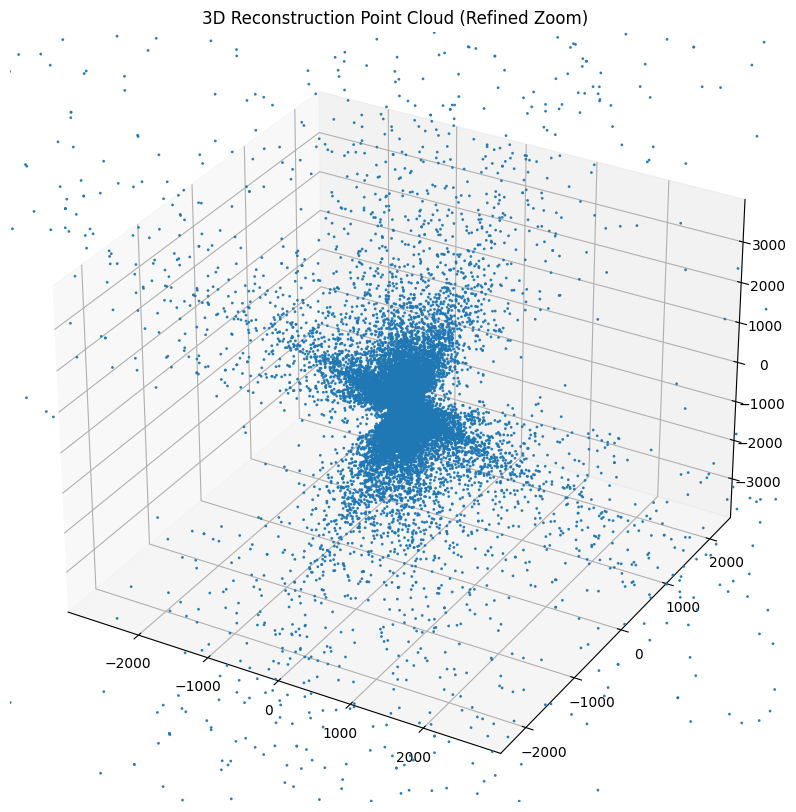

In [ ]:
# your code here
def visualize_3D_zoomed_refined(points_3D):
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    mean_x, mean_y, mean_z = np.mean(points_3D, axis=0)
    std_x, std_y, std_z = np.std(points_3D, axis=0)

    zoom_factor = 1  
    x_min, x_max = mean_x - zoom_factor * std_x, mean_x + zoom_factor * std_x
    y_min, y_max = mean_y - zoom_factor * std_y, mean_y + zoom_factor * std_y
    z_min, z_max = mean_z - zoom_factor * std_z, mean_z + zoom_factor * std_z

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], s=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_title("3D Reconstruction Point Cloud (Refined Zoom)")
    plt.show()

visualize_3D_zoomed_refined(final_3D_points)


# Visualising point cloud

In [ ]:
# import open3d as o3d

# file_path = r"C:\Users\Jawad Saeed\OneDrive - Higher Education Commission\ibi work\CV\PROJECT\deliverable_1\pantheon_exterior\pantheon_exterior\pantheon_exterior.ply"

# print("Loading the .ply file as a point cloud...")
# point_cloud = o3d.io.read_point_cloud(file_path)
# if not point_cloud.is_empty():
#     print("Point cloud loaded successfully!")
#     print(point_cloud)

#     print("Visualizing the point cloud...")
#     o3d.visualization.draw_geometries([point_cloud], window_name="Brandenburg Gate Point Cloud")
# else:
#     print("Failed to load the point cloud. Please check the file path and format.")


Loading the .ply file as a point cloud...
Point cloud loaded successfully!
PointCloud with 6183306 points.
Visualizing the point cloud...


### Evaluation
Evaluate the quality of your model. You can talk about how successfully you were able to reconstruct the landmark including aspects such as geometry accuracy, completeness, and texture detail (An answer of 5-6 lines will suffice).

**ANS:**
# Brandenburg:
For the bradenburg dataset as you can see in the ply file we were able to partially reconstruct the iconic landmark. But still the reconstruction was not perfect as seen by the two displaced pillars on the right side of the visualiztion. This is most probably due to incorrect matches due to interference from people in the images or from incorrect matches from images taken at different angles. In terms of geomtery the reconstruction was able to capture the shape of the gate overall. However intricate details such as the horses on the top of the gate were not captured propely due to lack of matches. Based on the mesh generated the texture seems to be good but not prefect as on rotating the model the mesh is deformed at the back side of the gate

# Pantheon:
The Pantheon point cloud captures some of the features, such as the triangular pediment and maybe some pillars (looks like pillars to me), especially when viewed from certain angles. However, the model has noticeable distortions and is incomplete, mainly because of the lack of continuity and similarity between consecutive images. The large crowds present in the scene added noise and obstructions, making the reconstruction more difficult. Overall, the quality isn't that good due to dataset having many images of humans infront of the pantheon which distorts the global poses and they do not give good 3d points when images are triangulated with each other. 